# CS4048 — Project II : Telco Customer Churn
**Step 1 — Frame the problem & Load data**

**Problem statement:**  
Predict whether a Telco customer will churn (`Churn` = Yes/No). This is a binary classification problem. Because missing churners is costly, our primary evaluation priority is **Recall** for the positive class (churners). 


In [1]:
# STEP 1: Load & Inspect the dataset
import pandas as pd
import numpy as np
import os


df = pd.read_csv('Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("\n=== SHAPE ===")
print(df.shape)

print("\n=== HEAD (first 5 rows) ===")
display(df.head(5))

print("\n=== INFO ===")
display(df.info())

print("\n=== MISSING VALUES (per column) ===")
print(df.isna().sum())

print("\n=== SUMMARY: object-type columns (these often hide data issues) ===")
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
print(obj_cols)

print('\\n=== Unique / sample values for suspicious columns ===')
if 'TotalCharges' in df.columns:
    print('\\nTotalCharges dtype:', df['TotalCharges'].dtype)
    # Show first 20 unique values (or fewer)
    print('TotalCharges unique sample (up to 20):')
    print(df['TotalCharges'].unique()[:20])
    # Count empty-string-like entries
    empty_like = df['TotalCharges'].apply(lambda x: isinstance(x, str) and x.strip()=='' ).sum()
    print('TotalCharges empty-string-like entries count:', empty_like)
else:
    print('TotalCharges not found in dataset!')

print('\\n=== Churn column sample values ===')
if 'Churn' in df.columns:
    print(df['Churn'].value_counts(dropna=False))
else:
    print('Churn column not found!')

# Also print number of rows and columns again for clarity
print("\\nNotebook check: finished Step 1. Now paste ALL above output here so I can review and give next cell.")



=== SHAPE ===
(7043, 21)

=== HEAD (first 5 rows) ===


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



=== INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-n

None


=== MISSING VALUES (per column) ===
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

=== SUMMARY: object-type columns (these often hide data issues) ===
['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']
\n=== Unique / sample values for suspicious columns ===
\nTotalCharges dtype: object
TotalCharges unique sample (up to 20):
['29.85' '1889.5

## Step 2 — Data Preprocessing

In this step, we clean the dataset exactly as the manual instructs:

1. **Fix `TotalCharges`**  
   - This column is incorrectly stored as `object` due to empty strings.  
   - Convert it to numeric with `errors="coerce"`.  
   - Drop rows where conversion fails (manual requirement).

2. **Convert `Churn` to binary**  
   - "Yes" → 1  
   - "No" → 0  

3. **Drop non-predictive column**  
   - Remove `customerID`.

4. **Identify numeric and categorical feature columns**  
   These will be used later for scaling and encoding.

After running the code cell, I will check the output before we proceed to Step 3.


In [2]:
# STEP 2 — Preprocessing 

print("Shape before fixing TotalCharges:", df.shape)

# 1) Fix TotalCharges: convert to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Count NaNs created
tc_nans = df['TotalCharges'].isna().sum()
print("TotalCharges NaNs after coercion:", tc_nans)

# 2) Drop rows with missing TotalCharges
before_drop = df.shape[0]
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)
after_drop = df.shape[0]

print(f"Rows before drop: {before_drop}")
print(f"Rows after drop : {after_drop}")
print(f"Rows dropped    : {before_drop - after_drop}")

# 3) Convert Churn to binary
print("\nChurn BEFORE mapping:")
print(df['Churn'].value_counts(dropna=False))

df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

print("\nChurn AFTER mapping:")
print(df['Churn'].value_counts(dropna=False))

# 4) Drop customerID
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])
    print("\nDropped 'customerID' column.")

# 5) Identify numeric & categorical columns
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols = [c for c in num_cols if c != 'Churn']  # remove target

cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Show final data snapshot
print("\n=== INFO after preprocessing ===")
display(df.info())

print("\n=== HEAD after preprocessing ===")
display(df.head())


Shape before fixing TotalCharges: (7043, 21)
TotalCharges NaNs after coercion: 11
Rows before drop: 7043
Rows after drop : 7032
Rows dropped    : 11

Churn BEFORE mapping:
Churn
No     5163
Yes    1869
Name: count, dtype: int64

Churn AFTER mapping:
Churn
0    5163
1    1869
Name: count, dtype: int64

Dropped 'customerID' column.

Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

=== INFO after preprocessing ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64 

None


=== HEAD after preprocessing ===


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## Step 3 — One-Hot Encoding, Train/Test Split, and Standard Scaling

### Manual Requirements:
1. Convert all categorical variables using **One-Hot Encoding** with `drop_first=True`.
2. Split data into **80% training** and **20% testing** using **stratified sampling** to preserve the churn proportion.
3. Apply **StandardScaler** ONLY on numeric columns and fit it on **training data only** to avoid data leakage.

After running the code cell below, I will check:
- Shape after encoding
- Feature column names
- Train/test proportions
- Whether scaling applied correctly


In [13]:
# STEP 3 — Encoding, Splitting, Scaling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# 3.1 One-Hot Encoding (drop_first=True)
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("Shape AFTER encoding:", df_encoded.shape)

# Separate X and y
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

print("\nNumber of features after encoding:", X.shape[1])

# 3.2 Train-test split (80/20, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("\nTrain shape:", X_train.shape)
print("Test shape :", X_test.shape)
print("Train churn proportion:", y_train.mean())
print("Test  churn proportion:", y_test.mean())

# 3.3 Standard Scaling NUMERIC columns ONLY
scaler = StandardScaler()

# intersect numeric columns (safe)
num_cols_present = [c for c in num_cols if c in X_train.columns]

print("\nNumeric columns being scaled:", num_cols_present)

# Fit ONLY on training data
scaler.fit(X_train[num_cols_present])

# Transform
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[num_cols_present] = scaler.transform(X_train[num_cols_present])
X_test_scaled[num_cols_present]  = scaler.transform(X_test[num_cols_present])

# Save scaler (manual suggests this for deployment)
joblib.dump(scaler, 'standard_scaler.pkl')

print("\nScaling complete. Scaler saved as standard_scaler.pkl")

# Show a preview after scaling
print("\n=== Preview of Scaled Numeric Columns (Train) ===")
display(X_train_scaled.head())


Shape AFTER encoding: (7032, 31)

Number of features after encoding: 30

Train shape: (5625, 30)
Test shape : (1407, 30)
Train churn proportion: 0.2657777777777778
Test  churn proportion: 0.2658137882018479

Numeric columns being scaled: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Scaling complete. Scaler saved as standard_scaler.pkl

=== Preview of Scaled Numeric Columns (Train) ===


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1408,-0.439319,1.321816,0.981556,1.659900,True,True,True,True,False,True,...,False,False,False,False,False,True,False,True,False,False
6992,-0.439319,-0.267410,-0.971546,-0.562252,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
3349,-0.439319,1.444064,0.837066,1.756104,False,True,False,True,False,True,...,False,False,False,False,False,True,False,True,False,False
4486,-0.439319,-1.204646,0.641092,-0.908326,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
3535,-0.439319,0.669826,-0.808787,-0.101561,False,True,False,False,True,False,...,False,True,False,False,False,False,False,False,False,False


## Step 4 — Exploratory Data Analysis (EDA)

In this step, we visually explore the dataset to understand patterns related to customer churn.

### We will generate:
1. **Churn distribution** — to check class imbalance  
2. **Distribution of numerical features** by churn  
3. **Churn rate for important categorical features**  
4. **Correlation heatmap** for numeric variables  

These plots will also be used later in the Word report.


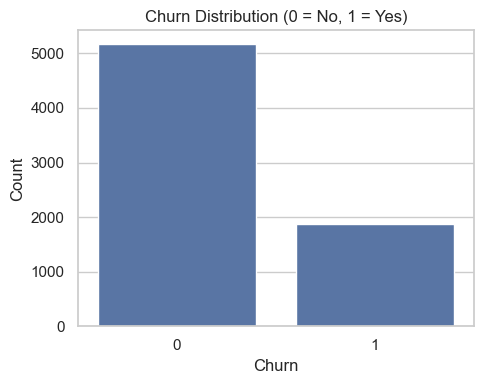


Churn proportion:
Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


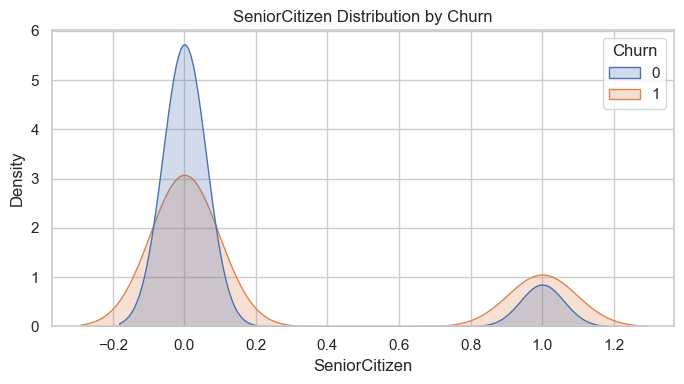

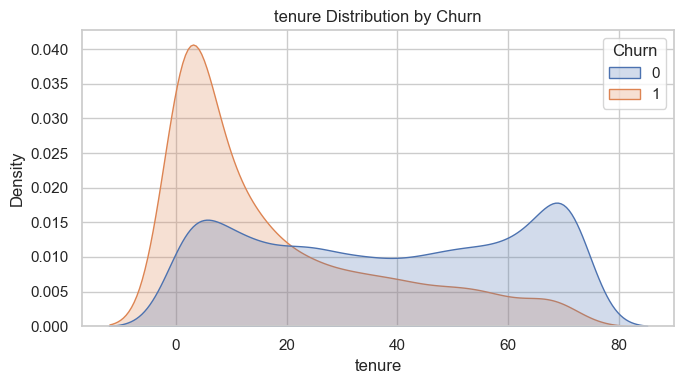

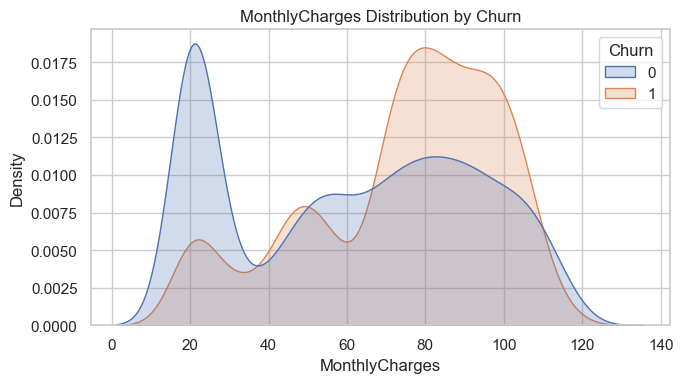

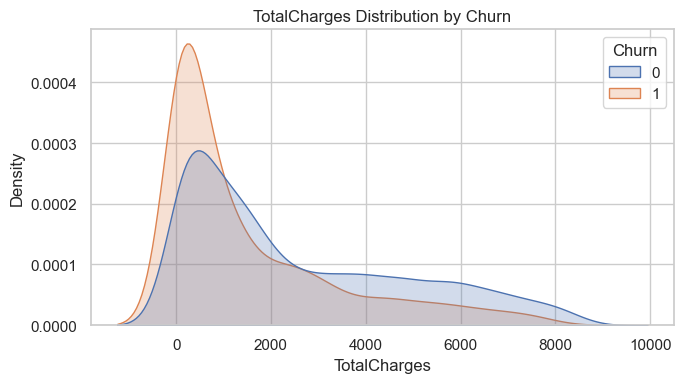

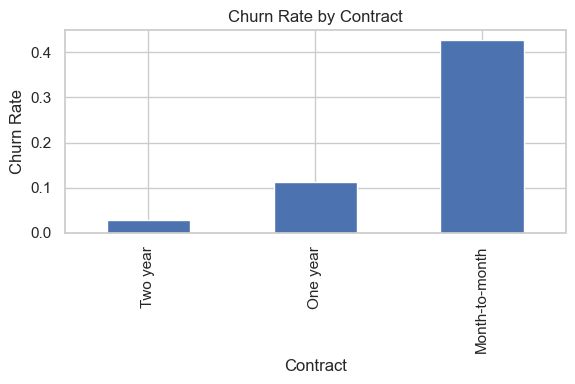


Churn rate by Contract:
Contract
Two year          0.028487
One year          0.112772
Month-to-month    0.427097
Name: Churn, dtype: float64


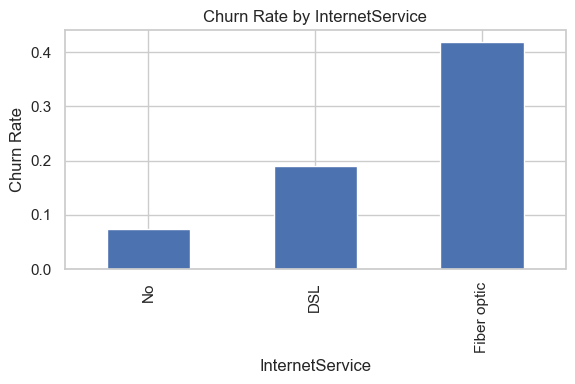


Churn rate by InternetService:
InternetService
No             0.074342
DSL            0.189983
Fiber optic    0.418928
Name: Churn, dtype: float64


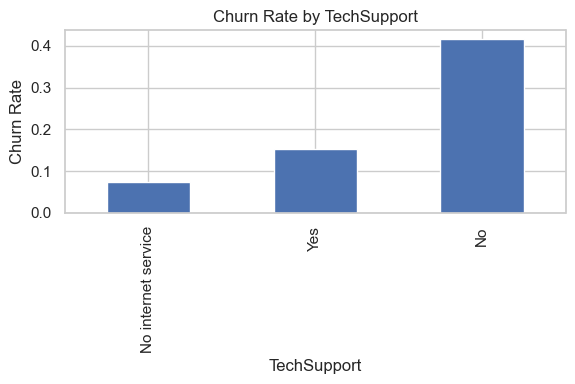


Churn rate by TechSupport:
TechSupport
No internet service    0.074342
Yes                    0.151961
No                     0.416475
Name: Churn, dtype: float64


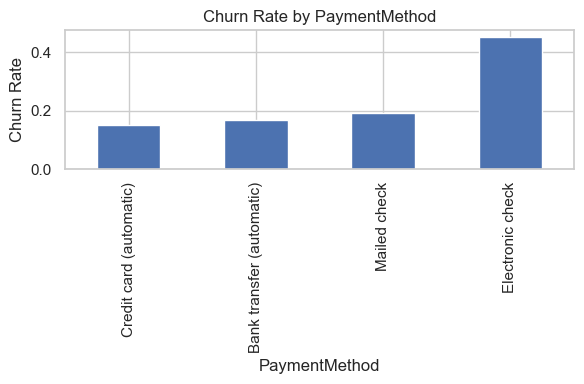


Churn rate by PaymentMethod:
PaymentMethod
Credit card (automatic)      0.152531
Bank transfer (automatic)    0.167315
Mailed check                 0.192020
Electronic check             0.452854
Name: Churn, dtype: float64


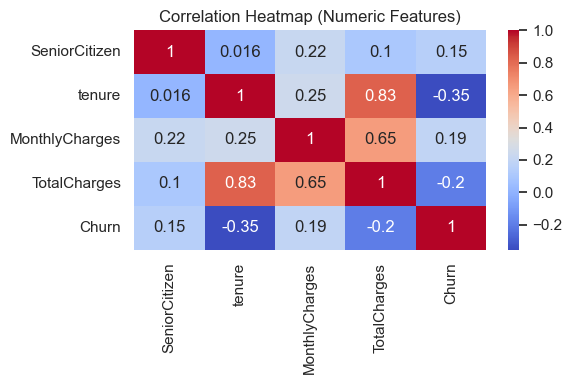

In [4]:
# STEP 4 — EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look clean
sns.set(style="whitegrid")

# --- 4.1 Churn Distribution ---
plt.figure(figsize=(5,4))
sns.countplot(x=df['Churn'])
plt.title("Churn Distribution (0 = No, 1 = Yes)")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("\nChurn proportion:")
print(df['Churn'].value_counts(normalize=True))


# --- 4.2 Numeric Feature Distributions by Churn ---
numeric_features = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

for col in numeric_features:
    plt.figure(figsize=(7,4))
    sns.kdeplot(data=df, x=col, hue='Churn', common_norm=False, fill=True)
    plt.title(f"{col} Distribution by Churn")
    plt.tight_layout()
    plt.show()


# --- 4.3 Churn Rate by Top Categorical Features ---
important_cats = ['Contract', 'InternetService', 'TechSupport', 'PaymentMethod']

for col in important_cats:
    plt.figure(figsize=(6,4))
    churn_rates = df.groupby(col)['Churn'].mean().sort_values()
    churn_rates.plot(kind='bar')
    plt.title(f"Churn Rate by {col}")
    plt.ylabel("Churn Rate")
    plt.tight_layout()
    plt.show()
    print(f"\nChurn rate by {col}:")
    print(churn_rates)


# --- 4.4 Correlation Heatmap for numeric features ---
plt.figure(figsize=(6,4))
sns.heatmap(df[numeric_features + ['Churn']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()


## Step 5 — Feature Engineering & Feature Importance

### Objectives:
1. Fit Logistic Regression on scaled training data and analyze:
   - Top features increasing churn
   - Top features reducing churn
2. Fit Random Forest and extract feature importances.
3. Compare which features appear consistently important across both models.

This step helps us understand which features drive customer churn, and prepares us for the model training stage.


=== Top 10 Positive Coefficients (Increase Churn) ===


,feature,coef
10,InternetService_Fiber optic,0.875708
3,TotalCharges,0.643220
28,PaymentMethod_Electronic check,0.375816
9,MultipleLines_Yes,0.314740
26,PaperlessBilling_Yes,0.288158
21,StreamingTV_Yes,0.278005
23,StreamingMovies_Yes,0.249365
0,SeniorCitizen,0.071785
29,PaymentMethod_Mailed check,0.066566
27,PaymentMethod_Credit card (automatic),0.030682



=== Top 10 Negative Coefficients (Reduce Churn) ===


,feature,coef
2,MonthlyCharges,-0.152454
15,OnlineBackup_Yes,-0.178544
8,MultipleLines_No phone service,-0.219999
6,Dependents_Yes,-0.231874
19,TechSupport_Yes,-0.380113
13,OnlineSecurity_Yes,-0.421753
24,Contract_One year,-0.752109
7,PhoneService_Yes,-0.760665
1,tenure,-1.351503
25,Contract_Two year,-1.365322



=== Top 10 Random Forest Feature Importances ===


,feature,importance
3,TotalCharges,0.191435
1,tenure,0.171020
2,MonthlyCharges,0.168400
10,InternetService_Fiber optic,0.039481
28,PaymentMethod_Electronic check,0.037416
25,Contract_Two year,0.030529
4,gender_Male,0.029332
13,OnlineSecurity_Yes,0.028157
26,PaperlessBilling_Yes,0.025536
19,TechSupport_Yes,0.024114


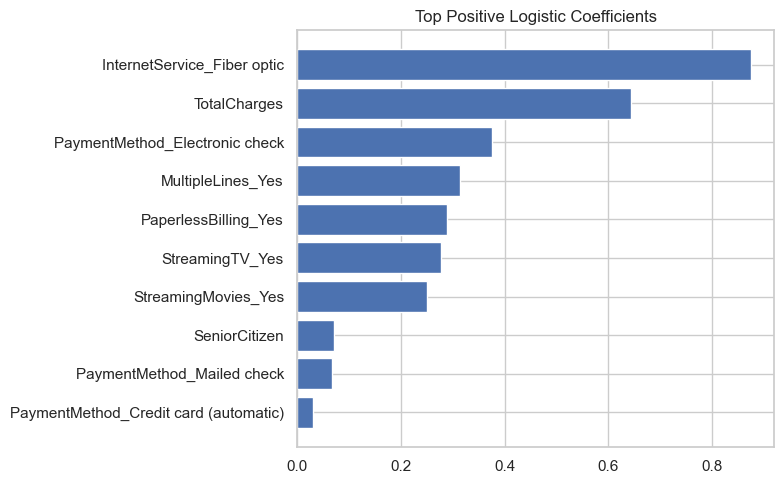

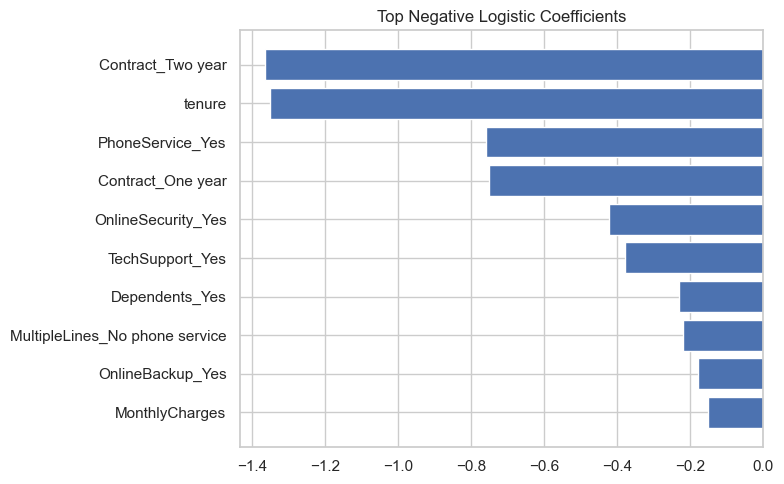

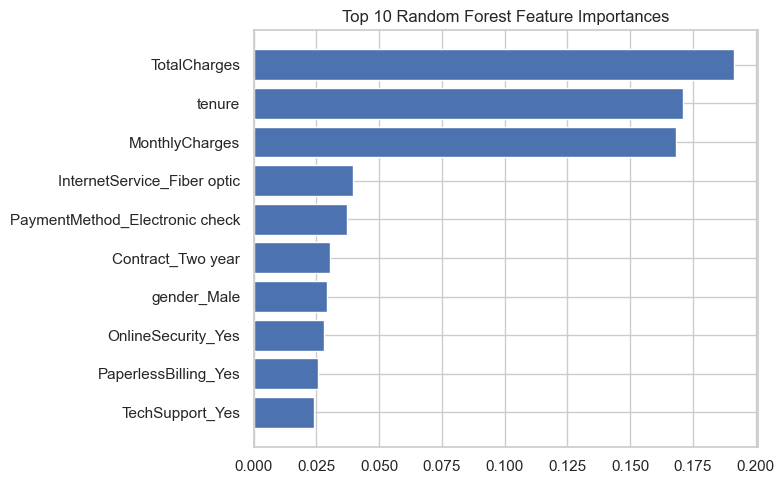

In [5]:
# STEP 5 — Feature Engineering & Feature Importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 5.1 Logistic Regression Coefficients
# -------------------------------

lr = LogisticRegression(max_iter=1000, solver='liblinear')
lr.fit(X_train_scaled, y_train)

# Create dataframe of coefficients
coef_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coef': lr.coef_[0]
})

# Sort by coefficient
coef_df_sorted = coef_df.sort_values(by='coef', ascending=False)

# Top positive (increase churn)
top_pos = coef_df_sorted.head(10)
# Top negative (reduce churn)
top_neg = coef_df_sorted.tail(10)

print("=== Top 10 Positive Coefficients (Increase Churn) ===")
display(top_pos)

print("\n=== Top 10 Negative Coefficients (Reduce Churn) ===")
display(top_neg)

# -------------------------------
# 5.2 Random Forest Feature Importances
# -------------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

importances_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\n=== Top 10 Random Forest Feature Importances ===")
display(importances_df.head(10))

# -------------------------------
# OPTIONAL: Simple bar charts for Word report
# -------------------------------

# Logistic positive
plt.figure(figsize=(8,5))
plt.barh(top_pos['feature'][::-1], top_pos['coef'][::-1])
plt.title("Top Positive Logistic Coefficients")
plt.tight_layout()
plt.show()

# Logistic negative
plt.figure(figsize=(8,5))
plt.barh(top_neg['feature'], top_neg['coef'])
plt.title("Top Negative Logistic Coefficients")
plt.tight_layout()
plt.show()

# Random Forest importances
plt.figure(figsize=(8,5))
plt.barh(importances_df['feature'].head(10)[::-1], importances_df['importance'].head(10)[::-1])
plt.title("Top 10 Random Forest Feature Importances")
plt.tight_layout()
plt.show()


## Step 6 — Model Training, Evaluation, and Selection

In this step, we train the models required by the manual:

1. **Logistic Regression** (baseline)
2. **Decision Tree (unconstrained)** — to show overfitting
3. **Decision Tree (pruned)** — using `max_depth=5`
4. **Random Forest** (Bagging method)

For each model, we evaluate:
- Training Accuracy
- Testing Accuracy
- Precision
- Recall (most important for churn)
- F1 Score

Finally, we create a comparison table and identify the best model based on **Recall**.


In [6]:
# STEP 6 — Model Training, Evaluation & Selection

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

results = {}

# Helper function
def evaluate_model(name, model):
    model.fit(X_train_scaled, y_train)
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    prec = precision_score(y_test, y_pred_test)
    rec = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)

    results[name] = {
        "Model": model,
        "Train_Acc": acc_train,
        "Test_Acc": acc_test,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    }

    print(f"\n=== {name} ===")
    print(f"Train Accuracy: {acc_train:.4f}")
    print(f"Test Accuracy : {acc_test:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")

# --------------------------
# 6.1 Logistic Regression
# --------------------------
lr_model = LogisticRegression(max_iter=1000, solver='liblinear')
evaluate_model("Logistic Regression", lr_model)

# --------------------------
# 6.2 Decision Tree (Unconstrained)
# --------------------------
dt_uncon = DecisionTreeClassifier(criterion='entropy', random_state=42)
evaluate_model("Decision Tree (Unconstrained)", dt_uncon)

# --------------------------
# 6.3 Decision Tree (Pruned)
# --------------------------
dt_pruned = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5, 
    random_state=42
)
evaluate_model("Decision Tree (Pruned)", dt_pruned)

# --------------------------
# 6.4 Random Forest
# --------------------------
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42
)
evaluate_model("Random Forest", rf_model)

# --------------------------
# 6.5 Comparison Table
# --------------------------
comparison_df = pd.DataFrame(results).T.drop(columns=["Model"])
print("\n\n=== Model Comparison Table ===")
display(comparison_df.sort_values(by="Recall", ascending=False))



=== Logistic Regression ===
Train Accuracy: 0.8039
Test Accuracy : 0.8031
Precision     : 0.6474
Recall        : 0.5695
F1 Score      : 0.6060

=== Decision Tree (Unconstrained) ===
Train Accuracy: 0.9988
Test Accuracy : 0.7278
Precision     : 0.4885
Recall        : 0.5107
F1 Score      : 0.4993

=== Decision Tree (Pruned) ===
Train Accuracy: 0.7931
Test Accuracy : 0.7754
Precision     : 0.5980
Recall        : 0.4733
F1 Score      : 0.5284

=== Random Forest ===
Train Accuracy: 0.9988
Test Accuracy : 0.7882
Precision     : 0.6234
Recall        : 0.5134
F1 Score      : 0.5630


=== Model Comparison Table ===


,Train_Acc,Test_Acc,Precision,Recall,F1
Logistic Regression,0.803911,0.803127,0.647416,0.569519,0.605974
Random Forest,0.998756,0.788202,0.623377,0.513369,0.56305
Decision Tree (Unconstrained),0.998756,0.72779,0.488491,0.510695,0.499346
Decision Tree (Pruned),0.793067,0.775409,0.597973,0.473262,0.528358


## Step 7 — Model Evaluation (Confusion Matrix & ROC Curve)

We evaluate the best model (Logistic Regression) more deeply using:

1. **Confusion Matrix** – shows True Positive, False Positive, False Negative, True Negative
2. **ROC Curve & AUC** – shows how well the model separates churners from non-churners


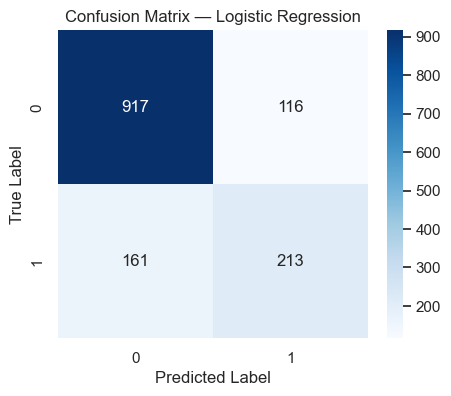


Confusion Matrix:
[[917 116]
 [161 213]]


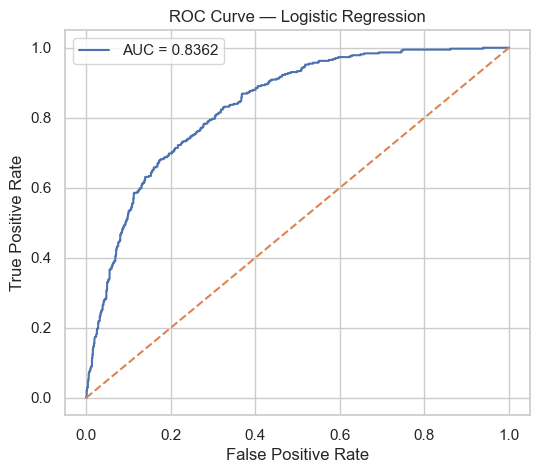


AUC Score: 0.8362


In [7]:
# STEP 7 — Confusion Matrix & ROC Curve

from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Use the best model (Logistic Regression)
best_model = lr_model

# Predictions
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# ---------------------
# Confusion Matrix
# ---------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("\nConfusion Matrix:")
print(cm)

# ---------------------
# ROC Curve
# ---------------------
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

print(f"\nAUC Score: {auc_score:.4f}")
